In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 10, 10
plt = mpl.pyplot
imshow = plt.imshow

import rawpy
import numpy as np

## Setup: Reading the Image

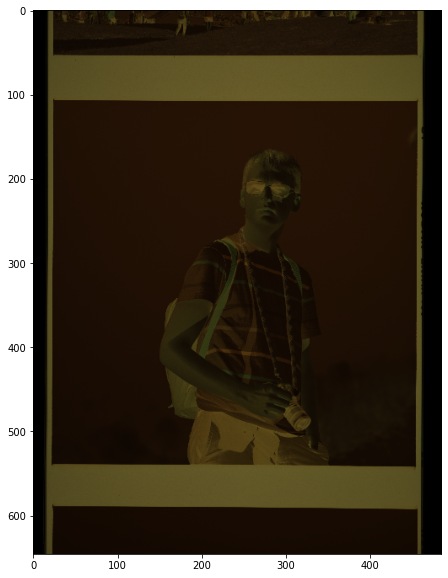

In [126]:
img_path = "../data/felix_2.iiq"
# img_path = "../data/lea.iiq"
# img_path = "../data/misty_mountains.iiq"
# img_path = "../data/steep_slope.iiq"

raw_data = rawpy.imread(img_path)

input = np.array(raw_data.postprocess(
            # TODO: make this conditional on user input or read full size lazily
            half_size=True,
            output_color=rawpy.ColorSpace.raw,
            output_bps=16,
            gamma=(1, 1),
            user_wb=[1.0, 1.0, 1.0, 1.0],
            no_auto_bright=True
            ), dtype=np.float32) / np.iinfo(np.uint16).max

# low res proxy
input = input[::8, ::8]
input = np.rot90(input, k=1, axes=(0, 1))
input = np.fliplr(input)

imshow(input)

## Finding the negative in the input

### Threshold to isolate boundaries

0.26166170835494995


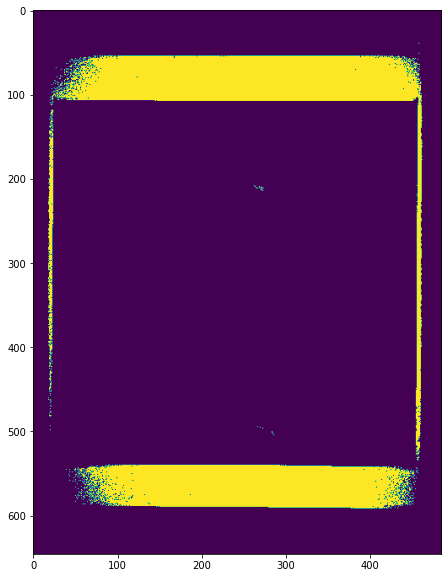

In [127]:
from skimage.filters import threshold_li, threshold_local

# threshold = threshold_li(input)
# threshold = threshold_local(input)
threshold = np.percentile(input, 88)

print (threshold)
mask = input.copy().mean(axis=2)
# threshold = 0.3
# mask[mask >= threshold] = 1
# mask[mask < threshold] = 0
mask = mask > threshold
imshow(mask)

### Find edges

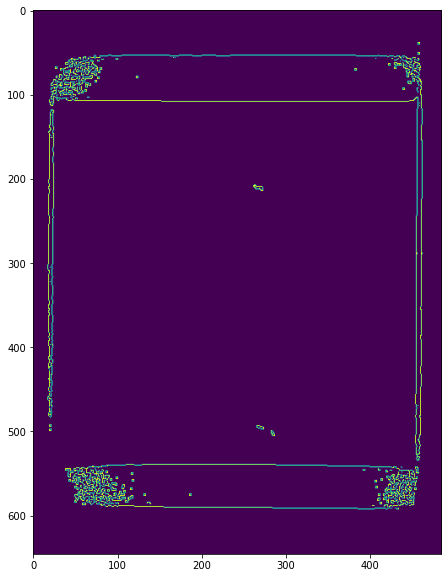

In [128]:
from skimage.feature import canny

edges = canny(mask)

imshow(edges)

### Turn edges into (long-ish) lines

In [129]:
from skimage.transform import probabilistic_hough_line

lines = probabilistic_hough_line(edges, threshold=5, line_length=100,
                                 line_gap=50)

lines

[((409, 53), (73, 53)),
 ((20, 499), (24, 220)),
 ((287, 539), (110, 539)),
 ((19, 253), (19, 106)),
 ((460, 108), (152, 108)),
 ((454, 569), (454, 244)),
 ((456, 544), (323, 540)),
 ((460, 446), (460, 224)),
 ((19, 345), (18, 232)),
 ((455, 175), (453, 56)),
 ((456, 543), (288, 540)),
 ((461, 223), (458, 38)),
 ((19, 499), (19, 346)),
 ((419, 592), (250, 590)),
 ((459, 517), (459, 352)),
 ((145, 589), (43, 544)),
 ((21, 89), (124, 78)),
 ((151, 107), (24, 107)),
 ((22, 326), (24, 189)),
 ((158, 590), (42, 557)),
 ((18, 481), (18, 289)),
 ((24, 188), (24, 82)),
 ((214, 590), (81, 588)),
 ((461, 158), (457, 38)),
 ((455, 289), (455, 176)),
 ((21, 499), (20, 397)),
 ((461, 169), (452, 56)),
 ((451, 587), (453, 456)),
 ((22, 443), (23, 335)),
 ((18, 212), (28, 67)),
 ((440, 585), (458, 481))]

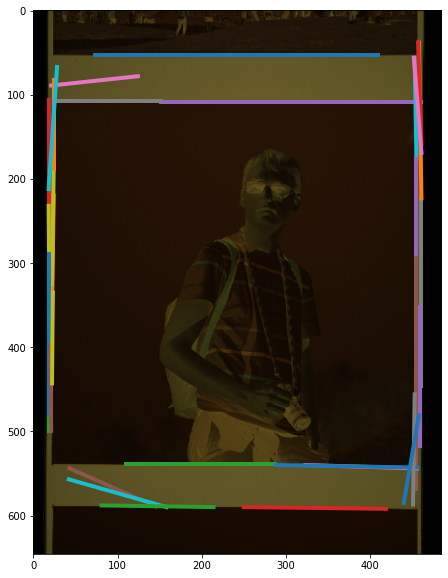

In [130]:
fig, ax = plt.subplots()
ax.imshow(input)

for line in lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=4)

### Glue: Angle calculation

In [131]:
def unit_vector(vector):
    """ Returns the unit vector of the vector."""
    return vector / np.linalg.norm(vector)

def vec_angle(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> vec_angle((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> vec_angle((1, 0, 0), (1, 0, 0))
            0.0
            >>> vec_angle((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

### Sort lines into left, right, top and bottom

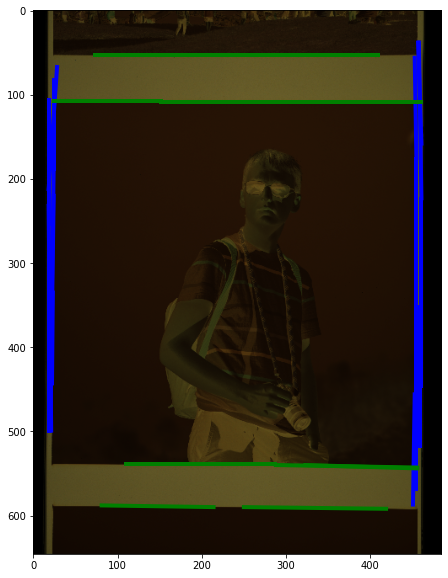

In [132]:
# sort lines into vertical and horizontal

angle_tolerance = 4

vertical = [l for l in lines if vec_angle(np.array(l[0]) - np.array(l[1]), (0, 1)) < angle_tolerance]
horizontal = [l for l in lines if vec_angle(np.array(l[0]) - np.array(l[1]), (1, 0)) < angle_tolerance]

fig, ax = plt.subplots()
ax.imshow(input)

for line in vertical:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=4, color="b")

for line in horizontal:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=4, color="g")

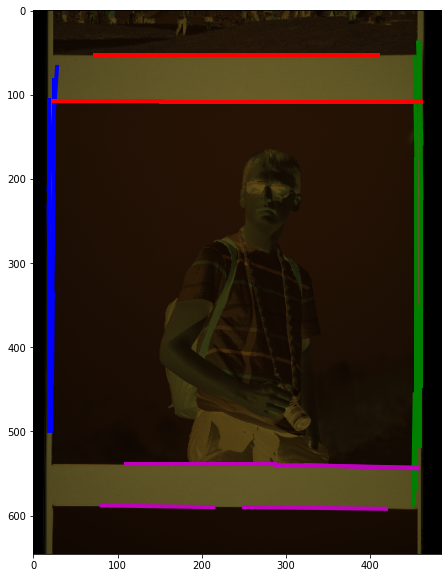

In [133]:
# sort vertical and horizontal lines into left/right and top/bottom

center = np.array(input.shape[:2]) / 2

v_left  = [l for l in vertical if l[0][0] < center[1] and l[1][0] < center[1]]
v_right = [l for l in vertical if l[0][0] > center[1] and l[1][0] > center[1]]

h_top    = [l for l in horizontal if l[0][1] < center[0] and l[1][1] < center[0]]
h_bottom = [l for l in horizontal if l[0][1] > center[0] and l[1][1] > center[0]]

fig, ax = plt.subplots()
ax.imshow(input)

for line in v_left:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=4, color="b")

for line in v_right:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=4, color="g")

for line in h_top:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=4, color="r")

for line in h_bottom:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=4, color="m")

### Select innermost lines from each category

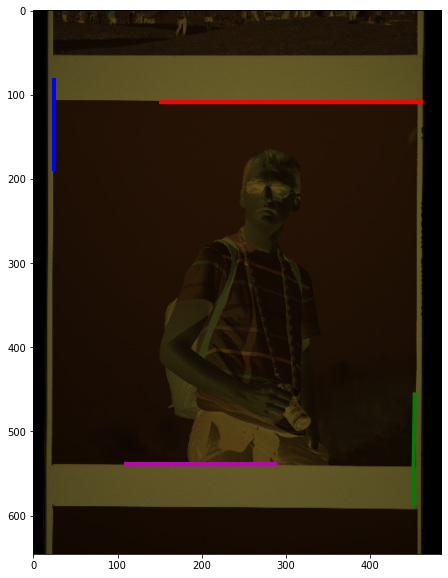

In [134]:
img_shape = (input.shape[:2][1], input.shape[:2][0])

left = ((0, 0), (0, 0))
for line in v_left:
    line_x_avg = (line[0][0] + line[1][0]) / 2
    left_x_avg = (left[0][0] + left[1][0]) / 2
    if line_x_avg > left_x_avg:
        left = line

right = (img_shape, img_shape)
for line in v_right:
    line_x_avg = (line[0][0] + line[1][0]) / 2
    right_x_avg = (right[0][0] + right[1][0]) / 2
    if line_x_avg < right_x_avg:
        right = line

top = ((0, 0), (0, 0))
for line in h_top:
    line_y_avg = (line[0][1] + line[1][1]) / 2
    top_y_avg = (top[0][1] + top[1][1]) / 2
    if line_y_avg > top_y_avg:
        top = line

bottom = (img_shape, img_shape)
for line in h_bottom:
    line_y_avg = (line[0][1] + line[1][1]) / 2
    bottom_y_avg = (bottom[0][1] + bottom[1][1]) / 2
    if line_y_avg < bottom_y_avg:
        bottom = line

fig, ax = plt.subplots()
ax.imshow(input)

p0, p1 = left
ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=4, color="b")

p0, p1 = right
ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=4, color="g")

p0, p1 = top
ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=4, color="r")

p0, p1 = bottom
ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=4, color="m")

### Crop image according to found lines (assuming no affine transform is necessary)

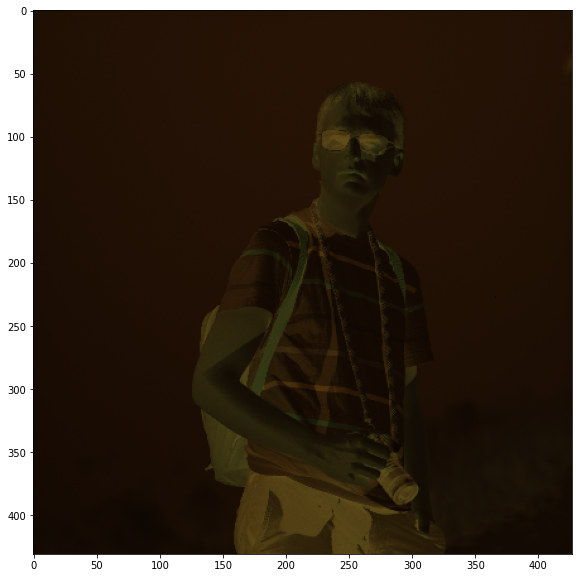

In [135]:
cropped = input[
    min(top[0][1], top[1][1]) : max(bottom[0][1], bottom[1][1]),
    max(left[0][0], left[1][0]) : min(right[0][0], right[1][0])
    ]

imshow(cropped)

### Crop image to found lines (with affine transform)

## As a reward for all that hard work: balance and invert the image

In [136]:
mask_3chan = np.stack((mask, mask, mask))
mask_3chan = np.moveaxis(mask_3chan, 0, 2)
# print(mask_3chan)
print(mask_3chan.shape, input.shape)
base = np.average(input, axis=(0, 1), weights=mask_3chan)
base

(646, 485, 3) (646, 485, 3)


array([0.37141952, 0.33293632, 0.14697656], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


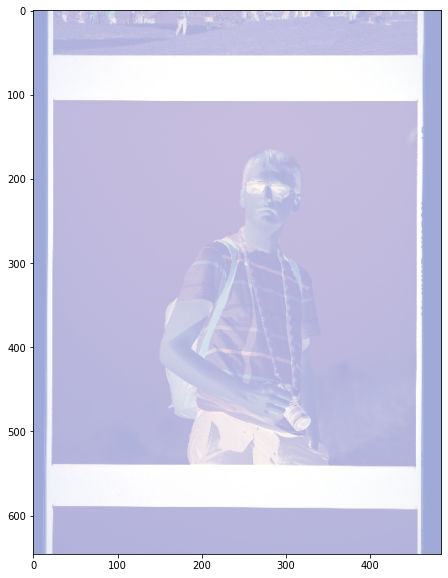

In [137]:
offset = 1 - base
imshow(input + offset)

[0.5873554, 1.0, 3.3124464, 1.0]


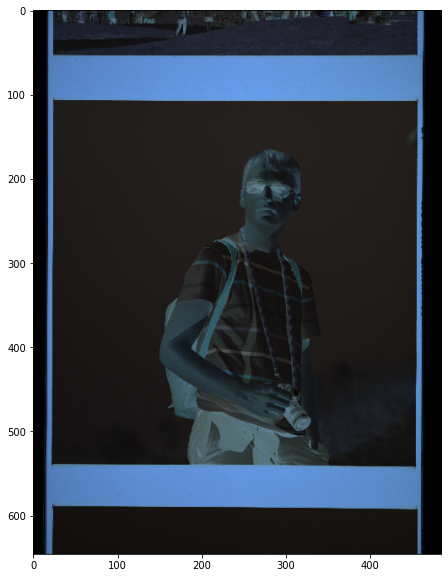

In [138]:
avg_r = np.mean(cropped[..., 0])
avg_g = np.mean(cropped[..., 1])
avg_b = np.mean(cropped[..., 2])

wb = [avg_g/avg_r, 1.0, avg_g/avg_b, 1.0]

print(wb)

white_balanced = np.array(raw_data.postprocess(
            half_size=True,
            output_color=rawpy.ColorSpace.raw,
            output_bps=16,
            gamma=(1, 1),
            user_wb=wb,
            no_auto_bright=True
            ), dtype=np.float32) / np.iinfo(np.uint16).max

# low res proxy
white_balanced = white_balanced[::8, ::8]
white_balanced = np.rot90(white_balanced, k=1, axes=(0, 1))
white_balanced = np.fliplr(white_balanced)
white_balanced = white_balanced

imshow(white_balanced)

In [139]:
wb_cropped = white_balanced[
    min(top[0][1], top[1][1]) : max(bottom[0][1], bottom[1][1]),
    max(left[0][0], left[1][0]) : min(right[0][0], right[1][0])
    ]

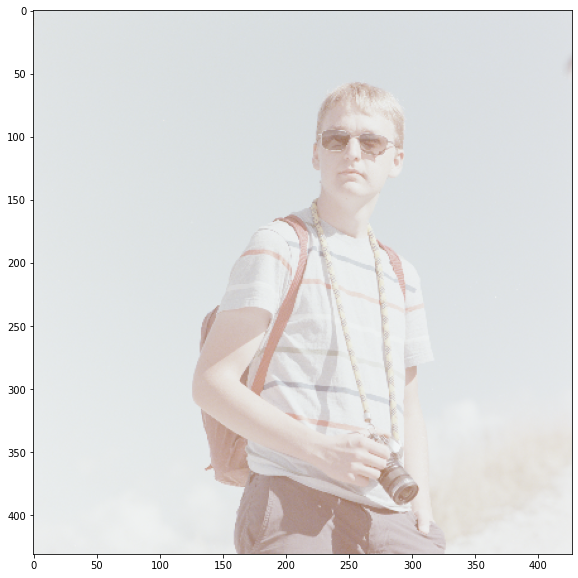

In [140]:
rawpy_inv = (1 - wb_cropped)
imshow(rawpy_inv)

In [141]:
rawpy_inv_avg = np.mean(rawpy_inv, axis=(0, 1))
print(rawpy_inv_avg)

[0.8690386 0.8690156 0.8690184]


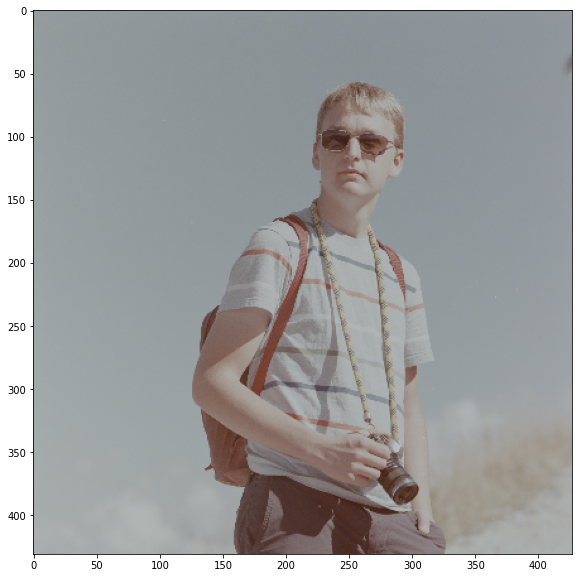

In [142]:
imshow((rawpy_inv * (1/rawpy_inv_avg) * 0.8) ** 2.5)
# TODO: this seems to be a decent algorithm - can we avoid the second raw conversion?

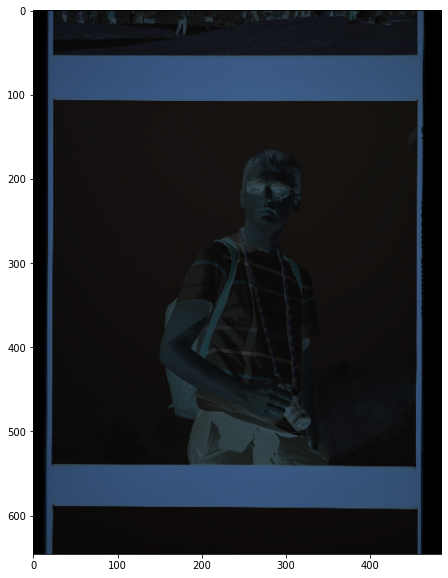

In [143]:
# manual_wb = (input + offset)
manual_wb = input * wb[:3]
imshow(manual_wb)

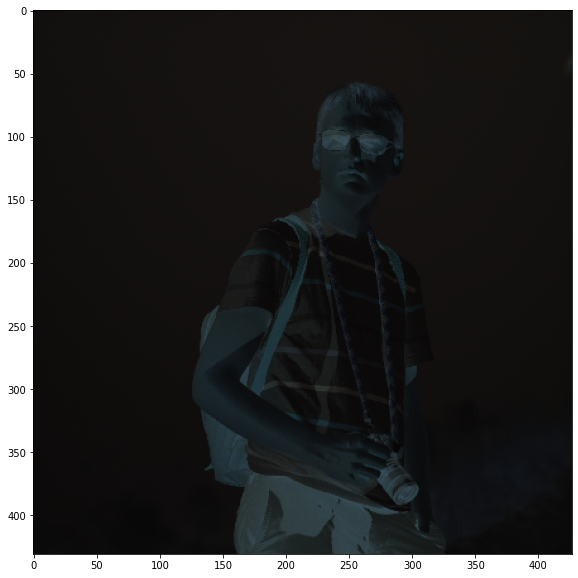

In [144]:
manual_wb_cropped = manual_wb[
    min(top[0][1], top[1][1]) : max(bottom[0][1], bottom[1][1]),
    max(left[0][0], left[1][0]) : min(right[0][0], right[1][0])
    ]

imshow(manual_wb_cropped)

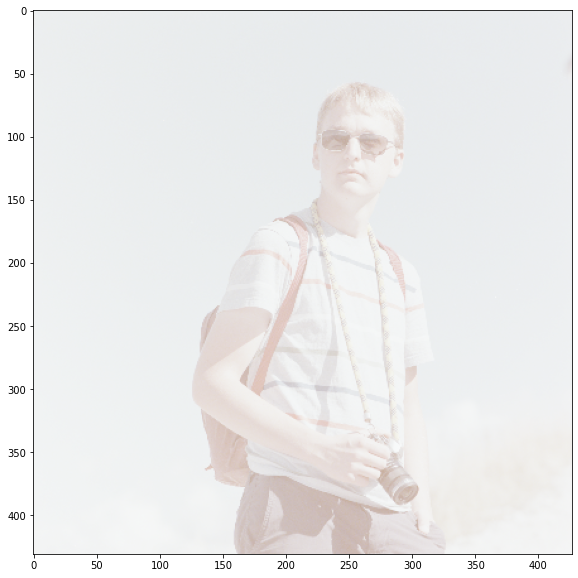

In [145]:
m_inv = 1 - manual_wb_cropped

imshow(m_inv)

In [146]:
m_inv_avg = np.mean(m_inv, axis=(0, 1))
print(m_inv_avg)

[0.92310403 0.92310403 0.92310404]


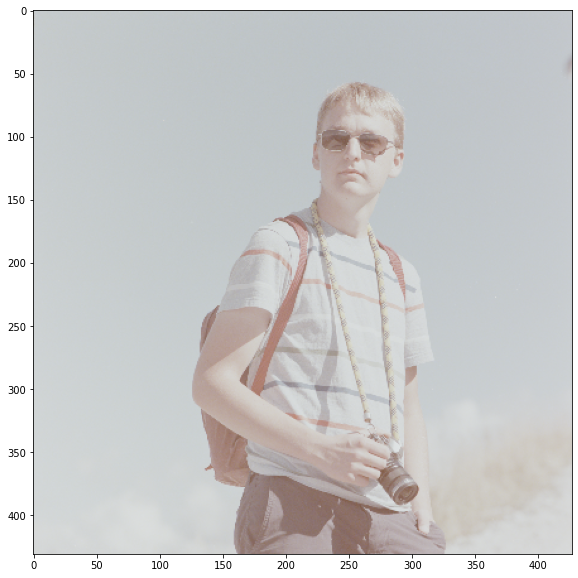

In [149]:
imshow((m_inv * (1/m_inv_avg) * 0.9) ** 2.5)